In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# MNIST Network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
base = 10
# MNIST Dataset (deterministic)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create datasets with fixed generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False, generator=g)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Example usage (deterministic training):
mnist_model = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_losses, trained_mnist = train_model(mnist_model, mnist_train_loader, mnist_criterion, mnist_optimizer, num_epochs=base, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda


In [5]:
mnist_inputs, mnist_activations, mnist_outputs = get_activations(trained_mnist, mnist_train_loader, dataset_type='mnist')

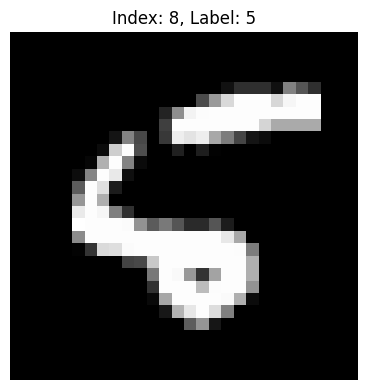


MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
8      5      5      1.0000      


In [6]:
sample_index = 8
k_neighbors = 15

# Show Example of dataset
show_mnist_samples(mnist_test_loader, indices=8)  # Single index

# Make prediction
print()
predictions_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=sample_index)  # Single index

single_mnist_inputs, single_mnist_activations, single_mnist_outputs = get_activations(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=sample_index)

In [7]:
indices_mnist, distances_mnist = find_knn(mnist_activations, single_mnist_activations, k=k_neighbors, metric='l2')
filtered_mnist_loader, filtered_size = create_filtered_dataloader(mnist_train_loader, exclude_indices=indices_mnist, batch_size=64, shuffle=False)

In [8]:
filter_mnist_model = MNISTNet()
mnist_criterion_f = nn.CrossEntropyLoss()
mnist_optimizer_f = optim.Adam(filter_mnist_model.parameters(), lr=0.001)
mnist_losses_f, filter_trained_mnist = train_model(filter_mnist_model, filtered_mnist_loader, mnist_criterion_f, mnist_optimizer_f, num_epochs=base, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda


In [9]:
# Base Model prediction
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=sample_index)

# Filtered Model prediction
predictions_filter_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(filter_trained_mnist, mnist_test_loader, dataset_type='mnist', indices=sample_index)

MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
8      5      5      1.0000      
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
8      5      5      0.9972      


In [10]:
print(nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist))
print(nn.CrossEntropyLoss()(predictions_filter_mnist, sample_targets_mnist))

tensor(2.2650e-06)
tensor(0.0028)


In [11]:
# def retrain_entropy_for_k_and_indices(model, train_loader, test_loader, list_of_k, list_of_indices, metric ='cosine'):
#     cross_results = {
#         'closest_cross_entropy': {},
#         'last_cross_entropy': {},
#         'random_cross_entropy': {}
#     }

#     # New: store k-NN distances per subset / k / sample
#     knn_distances = {
#         'closest_distances': {},
#         'last_distances': {},
#         'random_distances': {}
#     }

#     for k in list_of_k:
#         print(f"\n\n______Processing k={k}______\n\n")
#         cross_results['closest_cross_entropy'][k] = []
#         cross_results['last_cross_entropy'][k] = []
#         cross_results['random_cross_entropy'][k] = []

#         knn_distances['closest_distances'][k] = []
#         knn_distances['last_distances'][k] = []
#         knn_distances['random_distances'][k] = []

#         for index in list_of_indices:

#             # Get activations for the single sample
#             single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)

#             # Find k-nearest neighbors for the entire dataset (get full ordering + distances)
#             indices_knn, distances = find_knn(iris_activations, single_activations, k=len(iris_activations), metric=metric)

#             # Closest k neighbors and their distances
#             closest_indices = indices_knn[:k]
#             closest_dists = [float(d) for d in distances[:k]]

#             # Last k neighbors and their distances
#             last_indices = indices_knn[-k:]
#             last_dists = [float(d) for d in distances[-k:]]

#             # Random k neighbors (sampled from the ordering) and their distances
#             random_indices = np.random.choice(indices_knn, k, replace=False)
#             # build map for lookup
#             dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}
#             random_dists = [dist_map[int(i)] for i in random_indices]

#             for subset_name, subset_indices, subset_dists in zip(
#                     ['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'],
#                     [closest_indices, last_indices, random_indices],
#                     [closest_dists, last_dists, random_dists]):

#                 # Create filtered dataloader
#                 filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=16, shuffle=False)

#                 # Train a new model completely with the filtered dataset
#                 filtered_model = IrisNet()
#                 optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
#                 criterion = nn.CrossEntropyLoss()
#                 train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=base, seed=42, verbose=False, continue_training=False)

#                 # Predict and calculate CrossEntropy loss
#                 predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='iris', indices=index)
#                 cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
#                 cross_results[subset_name][k].append(cross_loss)

#                 # store the corresponding k distances
#                 dist_key = subset_name.replace('_cross_entropy', '_distances')
#                 knn_distances[dist_key][k].append(list(map(float, subset_dists)))

#     return cross_results, knn_distances

In [12]:
# Version 2: recompute activations on the filtered training set before k-NN so distances reflect the filtered dataset
# This is a copy of retrain_entropy_for_k_and_indices with the necessary changes; it returns the same (cross_results, knn_distances)

def retrain_entropy_for_k_and_indices_v2(model, train_loader, test_loader, list_of_k, list_of_indices, metric='cosine'):
    """Like retrain_entropy_for_k_and_indices but recalculates activations for the filtered
    training set before computing k-NN. This ensures stored k-NN distances are computed
    relative to the filtered dataset (i.e. after removing the excluded indices).

    Returns: cross_results, knn_distances (same structure as original)
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    # Store k-NN distances per subset / k / sample — distances here correspond to the filtered train set
    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample (from the provided model)
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='mnist', indices=index)

            # For each subset we will create the filtered dataloader first, then compute activations
            # for that filtered training set (using the same model) and then run k-NN between
            # the filtered training activations and the single sample's activations. This ensures
            # we measure distances relative to the filtered dataset.

            # Prepare neighbor candidates for the full filtered dataset.
            # We'll still exclude subset_indices from the original train set and compute activations on the remaining samples.
            for subset_name_template, subset_selector in [
                ('closest_cross_entropy', 'closest'),
                ('last_cross_entropy', 'last'),
                ('random_cross_entropy', 'random')
            ]:
                # To determine subset_indices we need the ordering of neighbors in the original (unfiltered) train set
                # Use mnist_activations (assumed available in the notebook) to get the full ordering; fall back to computing it
                try:
                    base_indices_knn, base_distances = find_knn(mnist_activations, single_activations, k=len(mnist_activations), metric=metric)
                except Exception:
                    # if mnist_activations not available, compute activations for full train_loader
                    _, full_train_activations, _ = get_activations(model, train_loader, dataset_type='mnist')
                    base_indices_knn, base_distances = find_knn(full_train_activations, single_activations, k=len(full_train_activations), metric=metric)

                if subset_selector == 'closest':
                    subset_indices = base_indices_knn[:k]
                    subset_dists_initial = [float(d) for d in base_distances[:k]]
                elif subset_selector == 'last':
                    subset_indices = base_indices_knn[-k:]
                    subset_dists_initial = [float(d) for d in base_distances[-k:]]
                else:  # random
                    # random selection from the base ordering (still referencing full train ordering)
                    subset_indices = np.random.choice(base_indices_knn, k, replace=False)
                    # build map for lookup
                    dist_map = {int(idx): float(d) for idx, d in zip(base_indices_knn, base_distances)}
                    subset_dists_initial = [dist_map[int(i)] for i in subset_indices]

                # Create filtered dataloader removing subset_indices
                filtered_loader, filtered_size = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Compute activations for the filtered training set using the same (base) model
                # This is the key change vs original: compute activations AFTER filtering
                if filtered_size == 0:
                    # nothing left in filtered set; record NaNs and continue
                    print(f"Filtered training set empty after excluding subset for index={index}, k={k}, subset={subset_name_template}")
                    cross_results[subset_name_template][k].append(float('nan'))
                    # store empty distance list
                    knn_distances[subset_name_template.replace('_cross_entropy', '_distances')][k].append([])
                    continue

                _, filtered_activations, _ = get_activations(model, filtered_loader, dataset_type='mnist')

                # If filtered_activations has fewer than k samples, adjust effective k
                eff_k = min(k, len(filtered_activations))

                # Run k-NN on the filtered activations against the single activation
                indices_knn_filtered, distances_filtered = find_knn(filtered_activations, single_activations, k=len(filtered_activations), metric=metric)

                # Derive the subset indices/dists relative to the filtered set ordering
                if subset_selector == 'closest':
                    sel_indices = indices_knn_filtered[:eff_k]
                    sel_dists = [float(d) for d in distances_filtered[:eff_k]]
                elif subset_selector == 'last':
                    sel_indices = indices_knn_filtered[-eff_k:]
                    sel_dists = [float(d) for d in distances_filtered[-eff_k:]]
                else:
                    # For random, sample from the filtered ordering (safe even if eff_k < k)
                    sel_indices = np.random.choice(indices_knn_filtered, eff_k, replace=False)
                    dist_map_filtered = {int(idx): float(d) for idx, d in zip(indices_knn_filtered, distances_filtered)}
                    sel_dists = [dist_map_filtered[int(i)] for i in sel_indices]

                # Now train on the filtered dataset (same as before)
                filtered_model = MNISTNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=base, seed=42, verbose=False, continue_training=False)

                # Predict and calculate CrossEntropy loss on the test sample
                predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='mnist', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name_template][k].append(cross_loss)

                # Store the distances we computed on the filtered dataset
                dist_key = subset_name_template.replace('_cross_entropy', '_distances')
                knn_distances[dist_key][k].append(list(map(float, sel_dists)))

    return cross_results, knn_distances


In [13]:
list_of_k = list(range(0, 101, 25))
list_of_k[0] = 1
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = list(range(0, 10000, 1))
random_indices = random.sample(list_of_indices, k=10)

print(list_of_k)
print(random_indices)

[1, 25, 50, 75, 100]
[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674]




______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9946      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9998      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9902      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
409

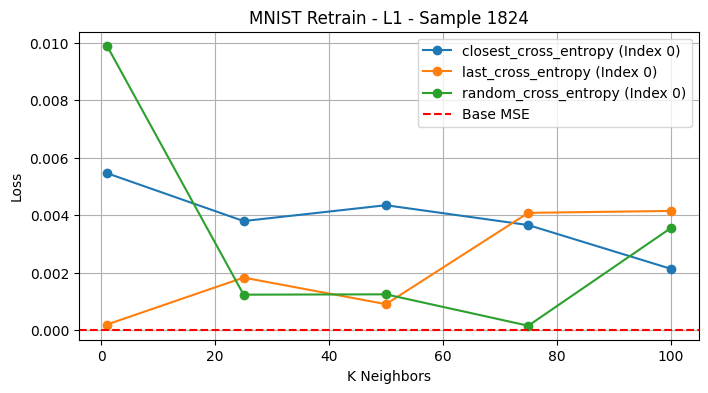

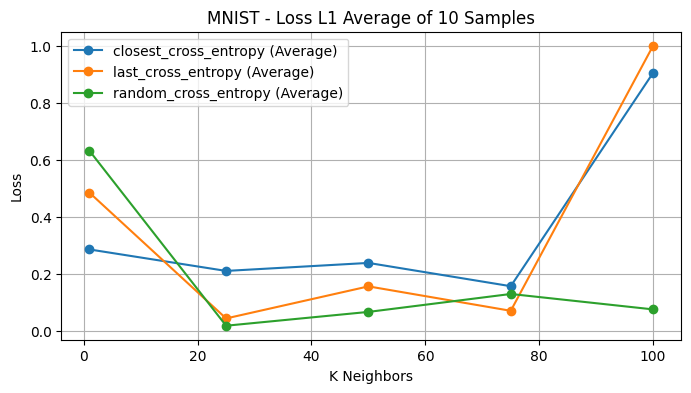

In [14]:
cross_results_l1, knn_distances_l1 = retrain_entropy_for_k_and_indices_v2(trained_mnist, mnist_train_loader, mnist_test_loader, list_of_k, random_indices,metric='l1')

# Save random_indices to a file
with open('retrain_data/100k/l1/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('retrain_data/100k/l1/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_l1, f)

# Save knn_distances to a file
with open('retrain_data/100k/l1/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_l1, f)  

index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_l1, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Retrain - L1 - Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(cross_results_l1, list_of_indices, average=True, normalize=True, title=f"MNIST - Loss L1 Average of {len(random_indices)} Samples", max_knn=max_knn)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9951      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      1.0000      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9983      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
409

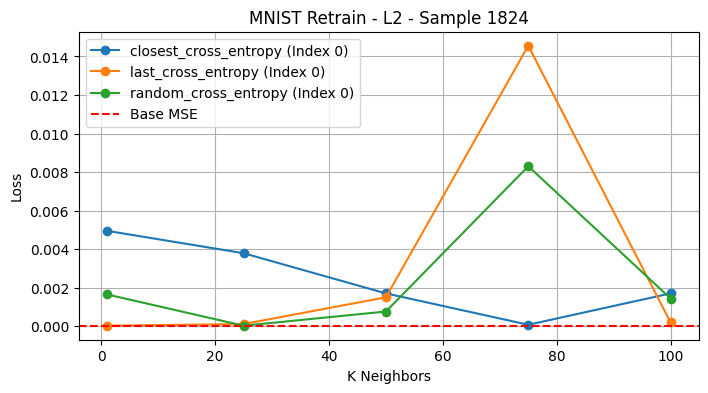

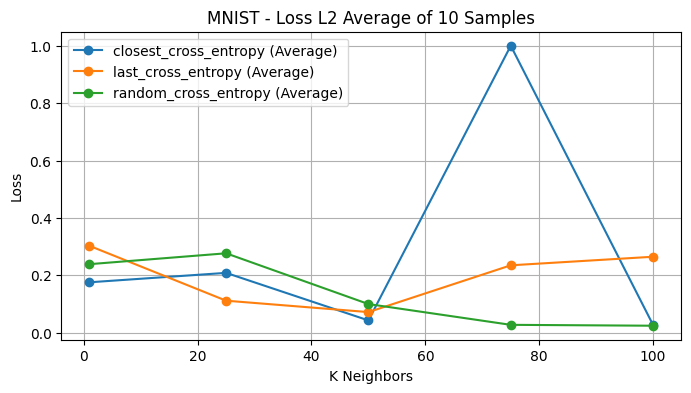

In [15]:
cross_results_l2, knn_distances_l2 = retrain_entropy_for_k_and_indices_v2(trained_mnist, mnist_train_loader, mnist_test_loader, list_of_k, random_indices,metric='l2')

# Save random_indices to a file
with open('retrain_data/100k/l2/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('retrain_data/100k/l2/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_l2, f)

# Save knn_distances to a file
with open('retrain_data/100k/l2/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_l2, f)  
    
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_l2, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Retrain - L2 - Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(cross_results_l2, list_of_indices, average=True, normalize=True, title=f"MNIST - Loss L2 Average of {len(random_indices)} Samples", max_knn=max_knn)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9951      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9920      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
1824   2      2      0.9776      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
409

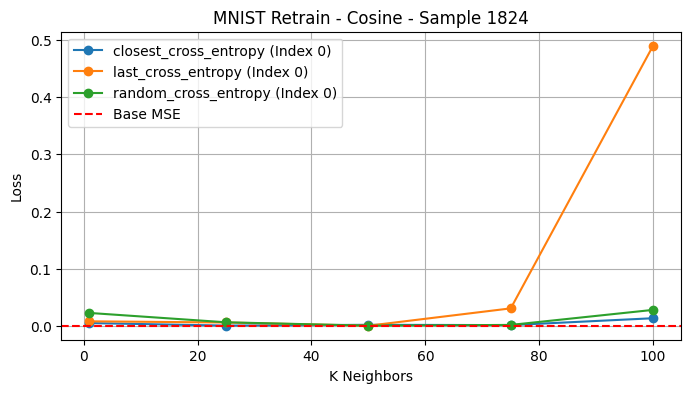

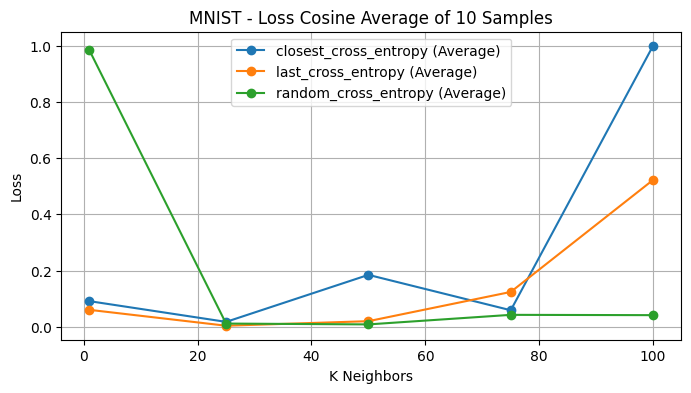

In [16]:
cross_results_cosine, knn_distances_cosine = retrain_entropy_for_k_and_indices_v2(trained_mnist, mnist_train_loader, mnist_test_loader, list_of_k, random_indices,metric='cosine')

# Save random_indices to a file
with open('retrain_data/100k/cosine/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('retrain_data/100k/cosine/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_cosine, f)

# Save knn_distances to a file
with open('retrain_data/100k/cosine/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_cosine, f)

index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_cosine, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Retrain - Cosine - Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(cross_results_cosine, list_of_indices, average=True, normalize=True, title=f"MNIST - Loss Cosine Average of {len(random_indices)} Samples", max_knn=max_knn)

In [17]:
knn_distances_cosine['closest_distances']

{1: [[0.023080110549926758],
  [0.010076642036437988],
  [0.03430086374282837],
  [0.04604661464691162],
  [0.020578384399414062],
  [0.03328251838684082],
  [0.01869034767150879],
  [0.02169656753540039],
  [0.005546212196350098],
  [0.00851142406463623]],
 25: [[0.04072678089141846,
   0.041058897972106934,
   0.041216135025024414,
   0.041731417179107666,
   0.041895389556884766,
   0.04264545440673828,
   0.042966365814208984,
   0.04312688112258911,
   0.043681323528289795,
   0.044171035289764404,
   0.0443730354309082,
   0.04484224319458008,
   0.04551839828491211,
   0.04589277505874634,
   0.046014249324798584,
   0.04638326168060303,
   0.04702240228652954,
   0.047574758529663086,
   0.04788476228713989,
   0.04799157381057739,
   0.048052072525024414,
   0.04821401834487915,
   0.04837942123413086,
   0.04851698875427246,
   0.04876202344894409],
  [0.015702366828918457,
   0.015795469284057617,
   0.015818417072296143,
   0.015905022621154785,
   0.015927910804748535,
   

In [18]:
# knn_distances['closest_distances'].items()

1: min=0.00554621  max=0.0460466  avg=0.022181
25: min=0.00915372  max=0.0866585  avg=0.0432491
50: min=0.0106796  max=0.100161  avg=0.0510574
75: min=0.0118123  max=0.10819  avg=0.0567089
100: min=0.0127295  max=0.115417  avg=0.0614552


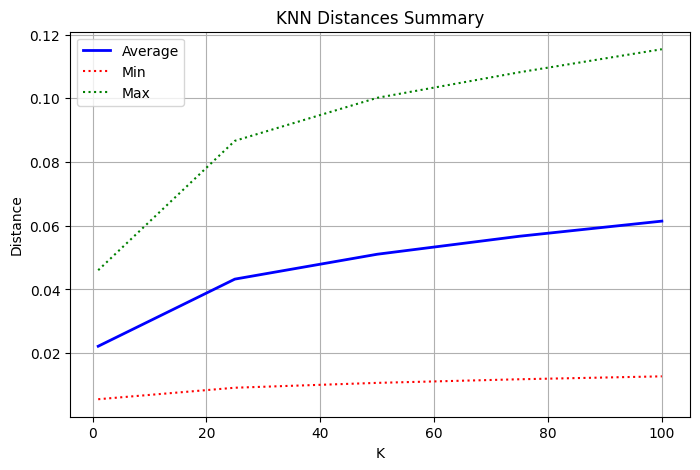

In [19]:
import statistics as stats

closest = knn_distances_cosine['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2)

# Plot min and max as dotted lines
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted")

plt.title("KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()    